In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import os.path
if not os.path.exists('mlp_helper.py'):
    !wget https://github.com/lab-ml-itba/MLP-2019/raw/master/mlp_helper.py

In [3]:
from mlp_helper import plot_boundaries_keras, get_dataset, plot_boundaries, draw_neural_net, return_weights_notation, get_dataset_2
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D 

# Pruebas a realizar:
- hidden_units en 2 y 3
- Cambiar funcion de activación de la capa oculta: Sigmoid, Relu, Linear

# Dataset

In [4]:
hidden_units = 5

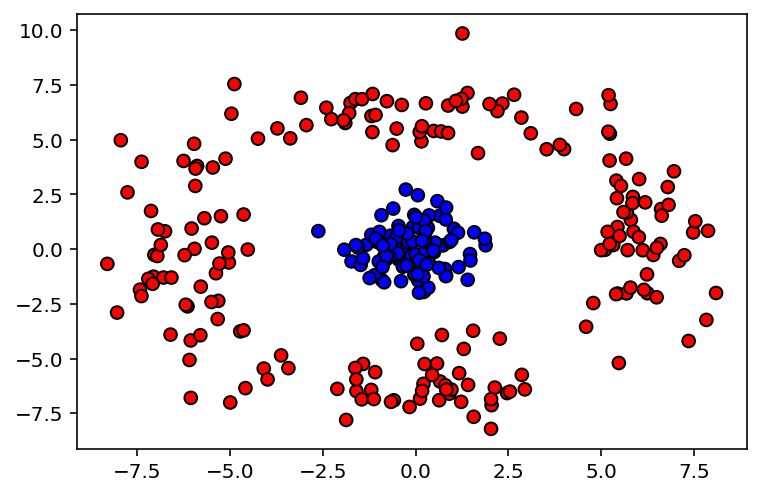

In [5]:
if hidden_units==2:
    X, y = get_dataset()
else:
    X, y = get_dataset_2()
plot_boundaries(X, y)

# Modelo: Red neuronal con 1 capa oculta

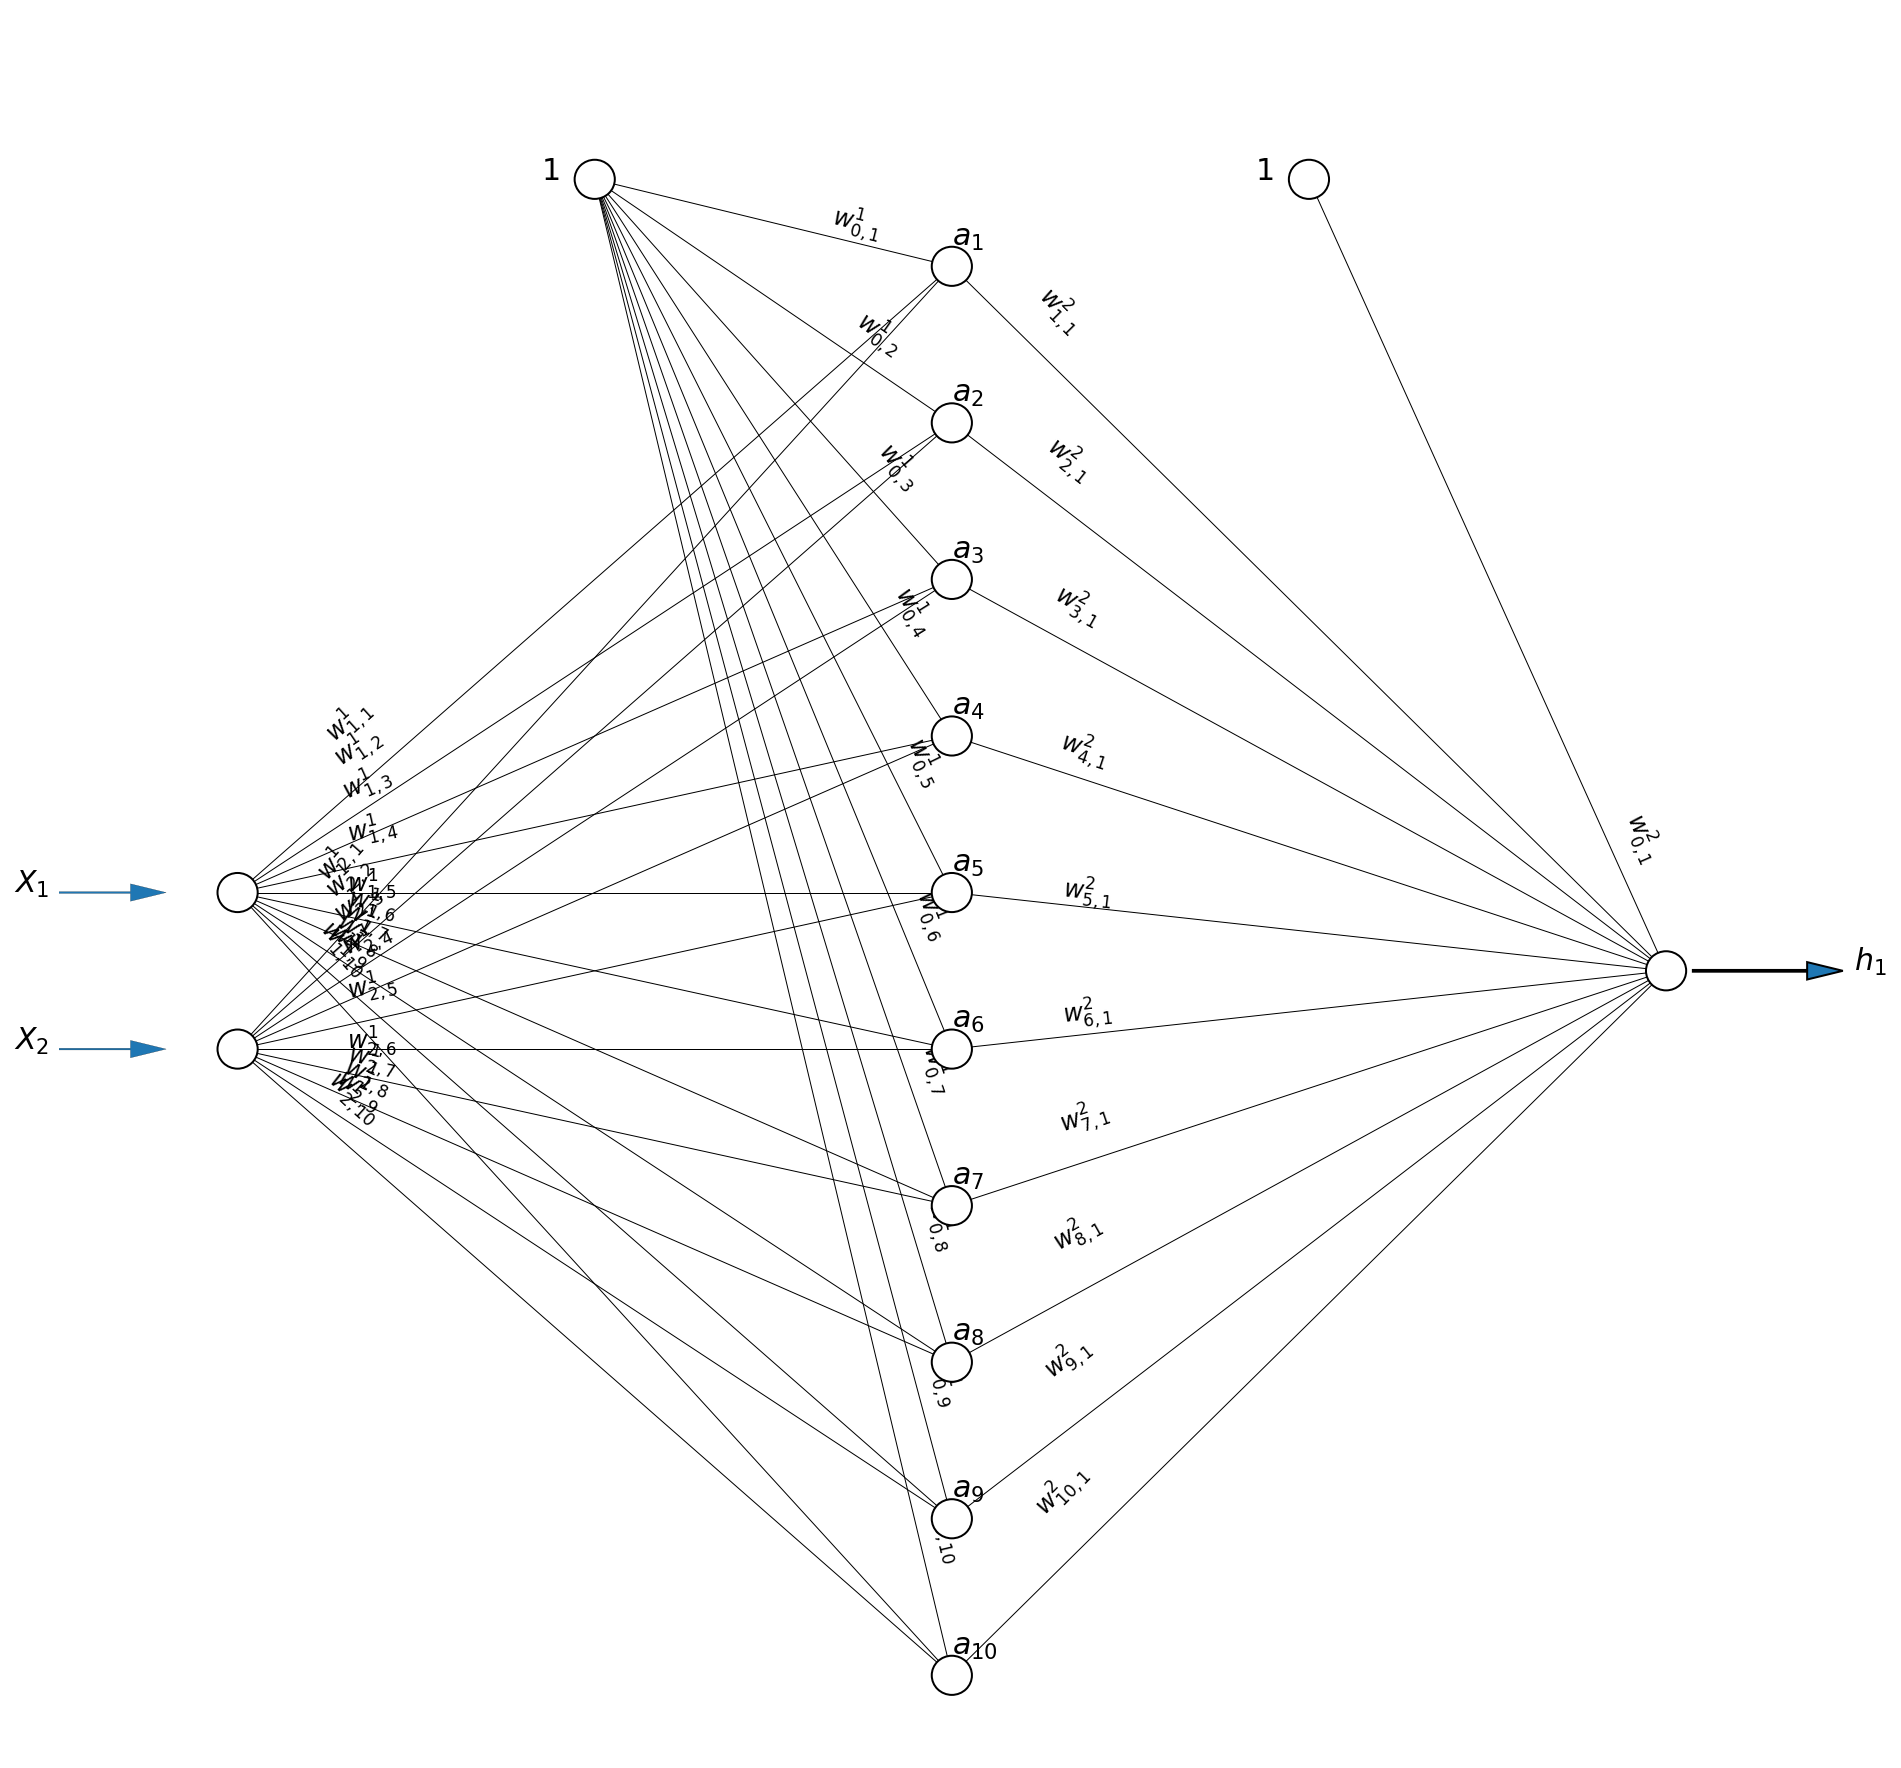

In [6]:
input_dim = 2

fig, ax = plt.subplots(1,1,figsize=(16, 16))
shape = [input_dim,10,1]
weights, biases = return_weights_notation(shape)
draw_neural_net(ax, 0.1, 0.9, 0, 0.9, shape, weights, biases, line_width=0.5)

In [7]:
from keras.models import Sequential
from keras.layers import Dense

### Selección de función de activación
https://medium.com/@himanshuxd/activation-functions-sigmoid-relu-leaky-relu-and-softmax-basics-for-neural-networks-and-deep-8d9c70eed91e

In [8]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [9]:
def plot_act(activ):
    t = np.linspace(-10, 10, 100)
    plt.plot(t, activ(t))
    plt.show()

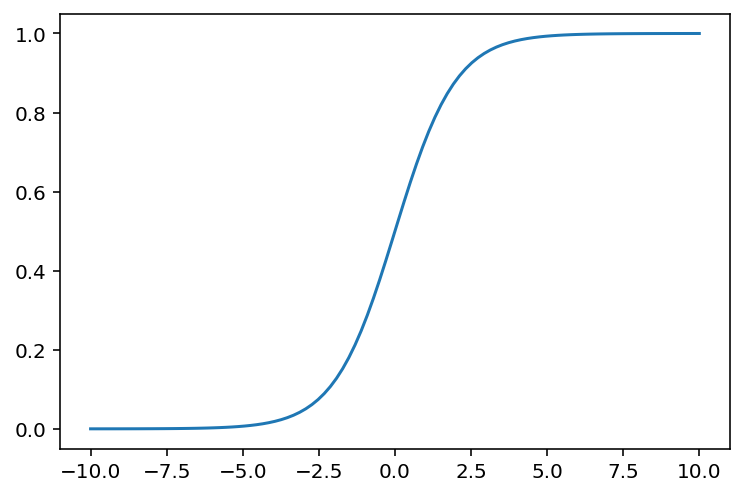

In [10]:
plot_act(sigmoid)

In [11]:
activation = 'relu' # linear, tanh, relu, tanh, sigmoid

In [12]:
model = Sequential()
model.add(Dense(hidden_units, input_shape=(input_dim,), activation=activation))
model.add(Dense(10, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 15        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                60        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 86
Trainable params: 86
Non-trainable params: 0
_________________________________________________________________


In [13]:
from keras.optimizers import Adam, SGD
model.compile(Adam(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
model.evaluate(X, y)

10/10 [==============================] - 0s 584us/step - loss: 0.7640 - accuracy: 0.5100


[0.7639956474304199, 0.5099999904632568]

In [15]:
weights = model.get_weights()
print(weights)

[array([[ 0.43649387, -0.77514136, -0.10739863,  0.7977418 , -0.55290127],
       [ 0.3338554 ,  0.80900466,  0.153543  ,  0.4960643 , -0.14395285]],
      dtype=float32), array([0., 0., 0., 0., 0.], dtype=float32), array([[ 0.06219327,  0.15846896, -0.49788782,  0.30224872,  0.6193313 ,
         0.55310434, -0.20424947,  0.05825692,  0.2196877 ,  0.5197657 ],
       [ 0.3165931 , -0.6207125 , -0.61183554, -0.16133142, -0.2862192 ,
         0.42561787, -0.5091937 , -0.01382738, -0.3063485 ,  0.06523591],
       [ 0.3886853 , -0.3375872 , -0.2133407 , -0.48100108,  0.292899  ,
         0.35226244,  0.29636025,  0.39394575, -0.20036921, -0.5467581 ],
       [-0.05370671,  0.05267727,  0.4804582 , -0.5497246 ,  0.47756642,
         0.55739063,  0.00715071,  0.12509543, -0.40796745,  0.12047935],
       [ 0.56315964,  0.44767112,  0.06308234, -0.5839227 , -0.01673609,
        -0.1823172 ,  0.33600092,  0.36368865, -0.5475911 ,  0.25967807]],
      dtype=float32), array([0., 0., 0., 0., 0.,

In [16]:
weights[0].shape, X[0:1].shape

((2, 5), (1, 2))

In [17]:
i = 1
sigmoid(np.dot(sigmoid(
    np.dot(X[i:i+1], weights[0]) + weights[1]), weights[2]) + weights[3])

array([[0.651863  , 0.42791671, 0.38392829, 0.30992808, 0.68102306,
        0.77350445, 0.45079961, 0.61593924, 0.33636906, 0.57281723]])

In [18]:
model.predict(X[i:i+1])

array([[0.68023705]], dtype=float32)

## Para recordar:

- Una red neuronal es la concatenación de capas
- Cada capa hace el producto entre el vector fila de entrada con la matriz de pesos, le suma el bias y luego aplica función de activación

# Entrenamiento

In [19]:
model.fit(X, y, epochs=500, verbose=0)

10/10 [==============================] - 0s 477us/step - loss: 7.7585e-06 - accuracy: 1.0000
Instructions for updating:
Please use `model.predict()` instead.


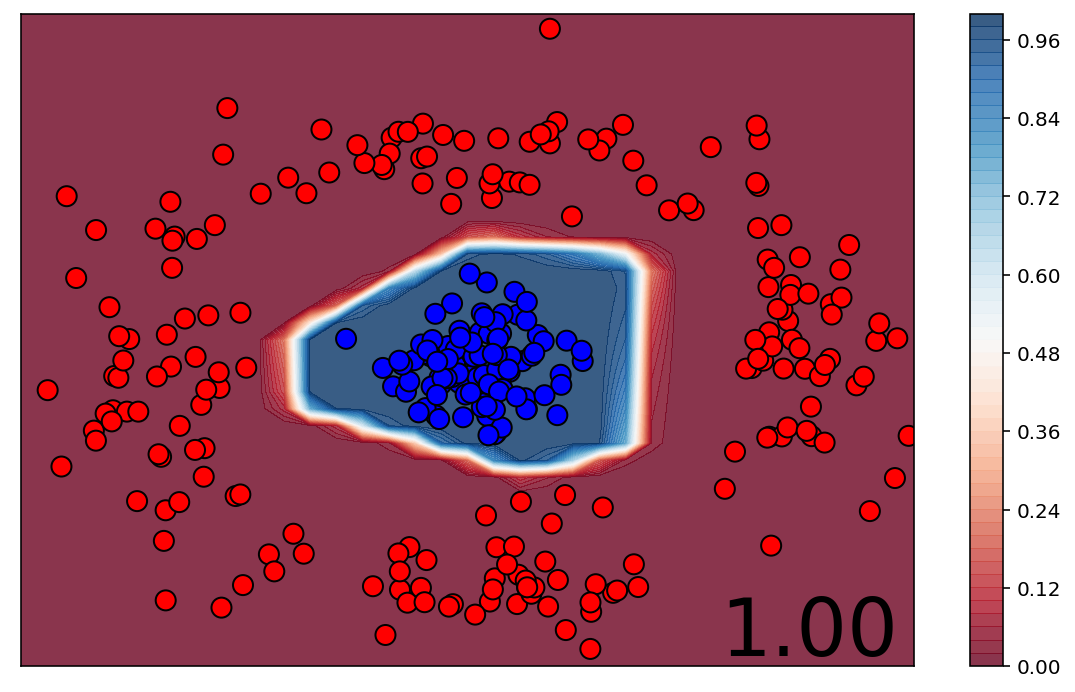

In [20]:
plt.figure(figsize=(10,6))
plot_boundaries_keras(X, y, model.evaluate(X,y)[1], probability_func=model.predict_proba, h=0.5)

In [21]:
model.predict_proba(X).shape

(300, 1)

## Obtenemos pesos de primera capa
### Pesos aprendidos

In [22]:
model.get_weights()

[array([[ 0.02407041, -0.700475  , -0.42016423,  1.4604868 , -0.39815494],
        [ 0.25429362,  1.1202585 ,  0.6305813 ,  0.20476498, -0.79285395]],
       dtype=float32),
 array([ 1.3258793 , -1.079918  , -0.866979  , -0.52177316, -0.7346458 ],
       dtype=float32),
 array([[-0.26136172, -0.40194327,  0.28556368,  1.0818806 ,  1.027983  ,
          1.3734901 , -0.29203993,  0.14559834,  0.9929416 ,  0.52097285],
        [ 0.18184403,  0.0458243 , -0.3624614 , -0.41367093, -0.6684372 ,
          0.62781703,  0.0215231 , -0.42761746, -0.51904947, -0.19625904],
        [ 0.91450197,  1.3486174 , -0.86293536, -1.1855382 , -0.4664035 ,
          0.41443518,  1.3360271 , -0.345569  , -0.8850573 , -0.9897442 ],
        [ 0.40341905,  0.45299715, -0.5305235 , -0.7022677 , -0.64494413,
          0.45457336,  0.41887054, -0.38637894, -0.6630219 , -0.47679433],
        [ 1.0985007 ,  1.0681497 , -1.3986148 , -1.0833039 , -0.8338405 ,
         -0.74265546,  1.0574492 , -1.0705632 , -1.0993927 

In [23]:
# Nos quedamos con los pesos de la primer capa
layer_1_w = model.get_weights()[0]
layer_1_b = model.get_weights()[1]
print(layer_1_w)
print(layer_1_b)

[[ 0.02407041 -0.700475   -0.42016423  1.4604868  -0.39815494]
 [ 0.25429362  1.1202585   0.6305813   0.20476498 -0.79285395]]
[ 1.3258793  -1.079918   -0.866979   -0.52177316 -0.7346458 ]


In [24]:
# Preparo los pesos a asignar a un "submodelo" de "regresión logistica"
model_1_weights = [np.array([layer_1_w[:,0]]).T, np.array([layer_1_b[0]])]
print(model_1_weights)

[array([[0.02407041],
       [0.25429362]], dtype=float32), array([1.3258793], dtype=float32)]


In [25]:
# Construimos el submodelo
model_1 = Sequential()
model_1.add(Dense(1, input_shape=(2,), activation=activation))
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [358]:
# Le asginamos los pesos al submodelo
model_1.set_weights(model_1_weights)
model_1.compile(Adam(lr=0.1), loss='binary_crossentropy', metrics=['accuracy'])

300/300 [==============================] - 0s 383us/step


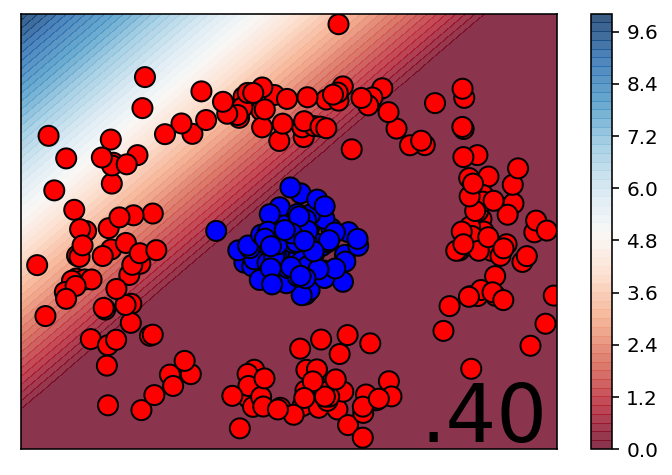

In [359]:
plot_boundaries_keras(X, y, model_1.evaluate(X,y)[1], probability_func=model_1.predict_proba, h=0.5)

### Generalizo función para armar submodelo
Y grafico los dos submodelos

In [360]:
def get_sub_model(model, index, idx1=0, idx2=1, activation='sigmoid', input_dim=2):
    layer_1_w = model.get_weights()[idx1]
    layer_1_b = model.get_weights()[idx2]
    sub_model_weights = [np.array([layer_1_w[:,index]]).T, np.array([layer_1_b[index]])]
    sub_model = Sequential()
    sub_model.add(Dense(1, input_shape=(input_dim,), activation=activation))
    sub_model.set_weights(sub_model_weights)
    sub_model.compile(Adam(lr=0.1), loss='binary_crossentropy', metrics=['accuracy'])
    return sub_model

### Graficamos las rectas aprendidas por los submodelos

300/300 [==============================] - 0s 420us/step


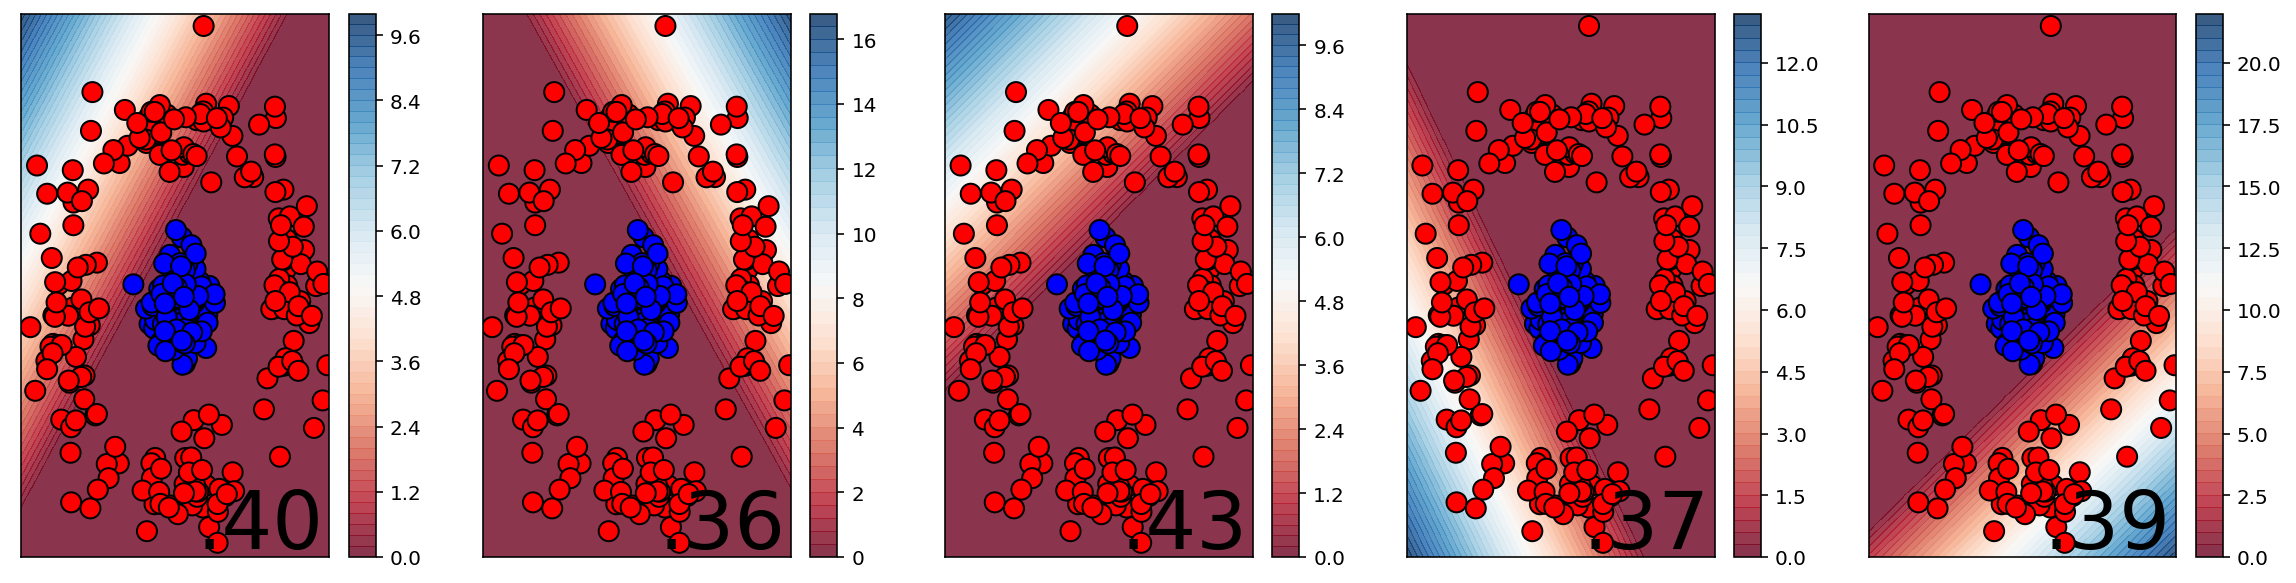

In [361]:
f, ax = plt.subplots(1, hidden_units, figsize=(20,5))
sub_models = []

# Para el mesh-grid
N = 300
X1 = np.linspace(X[:, 0].min(), X[:, 0].max(), N)
X2 = np.linspace(X[:, 1].min(), X[:, 1].max(), N)

X1, X2 = np.meshgrid(X1, X2)
Z_lr_array = []

for i in range(hidden_units):
    sub_model = get_sub_model(model, i, activation=activation)
    sub_models.append(sub_model)
    Z_lr = sub_model.predict_proba(np.c_[X1.ravel(), X2.ravel()])[:, 0]
    Z_lr = Z_lr.reshape(X1.shape)
    Z_lr_array.append(Z_lr)
    plot_boundaries_keras(X, y, sub_model.evaluate(X,y)[1], probability_func=sub_model.predict_proba, ax=ax[i], h=0.5)

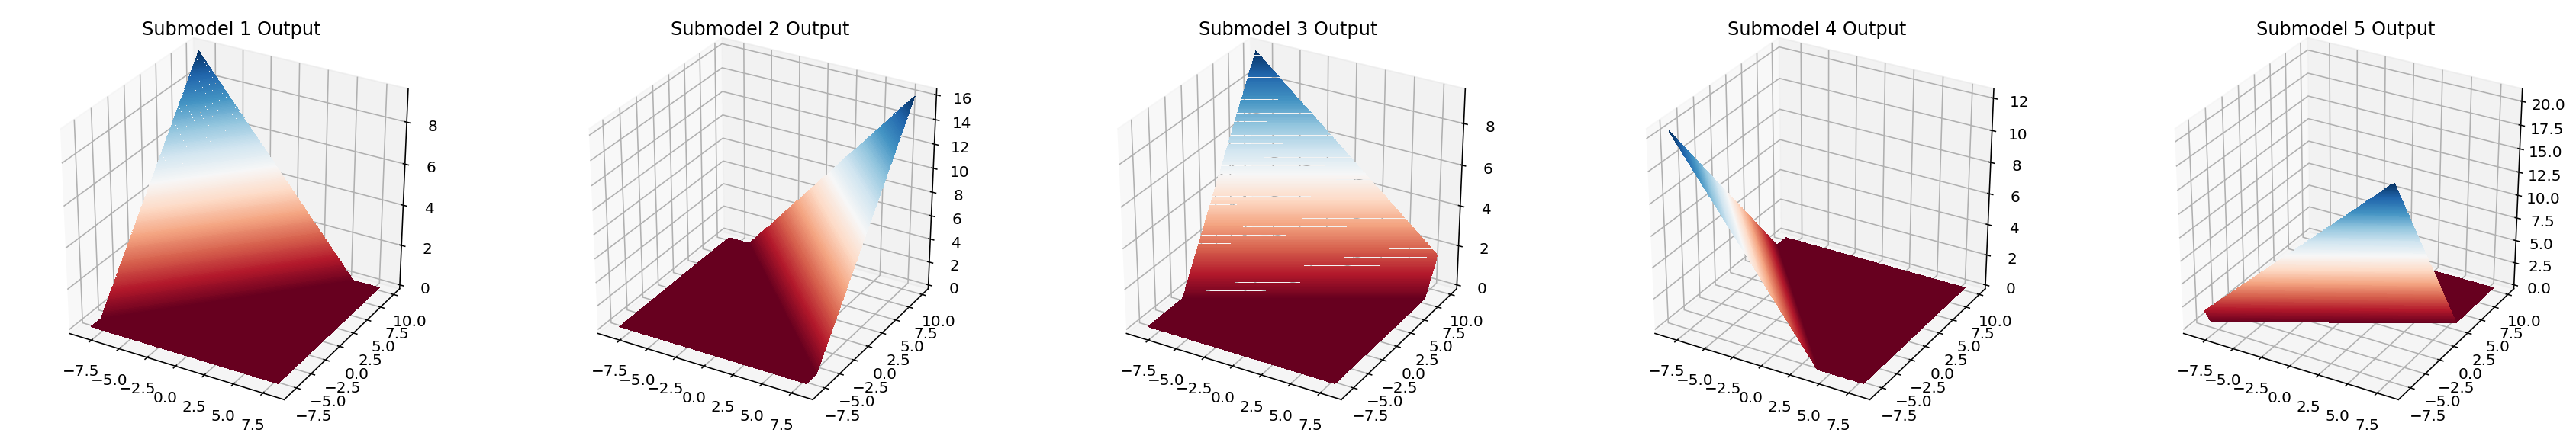

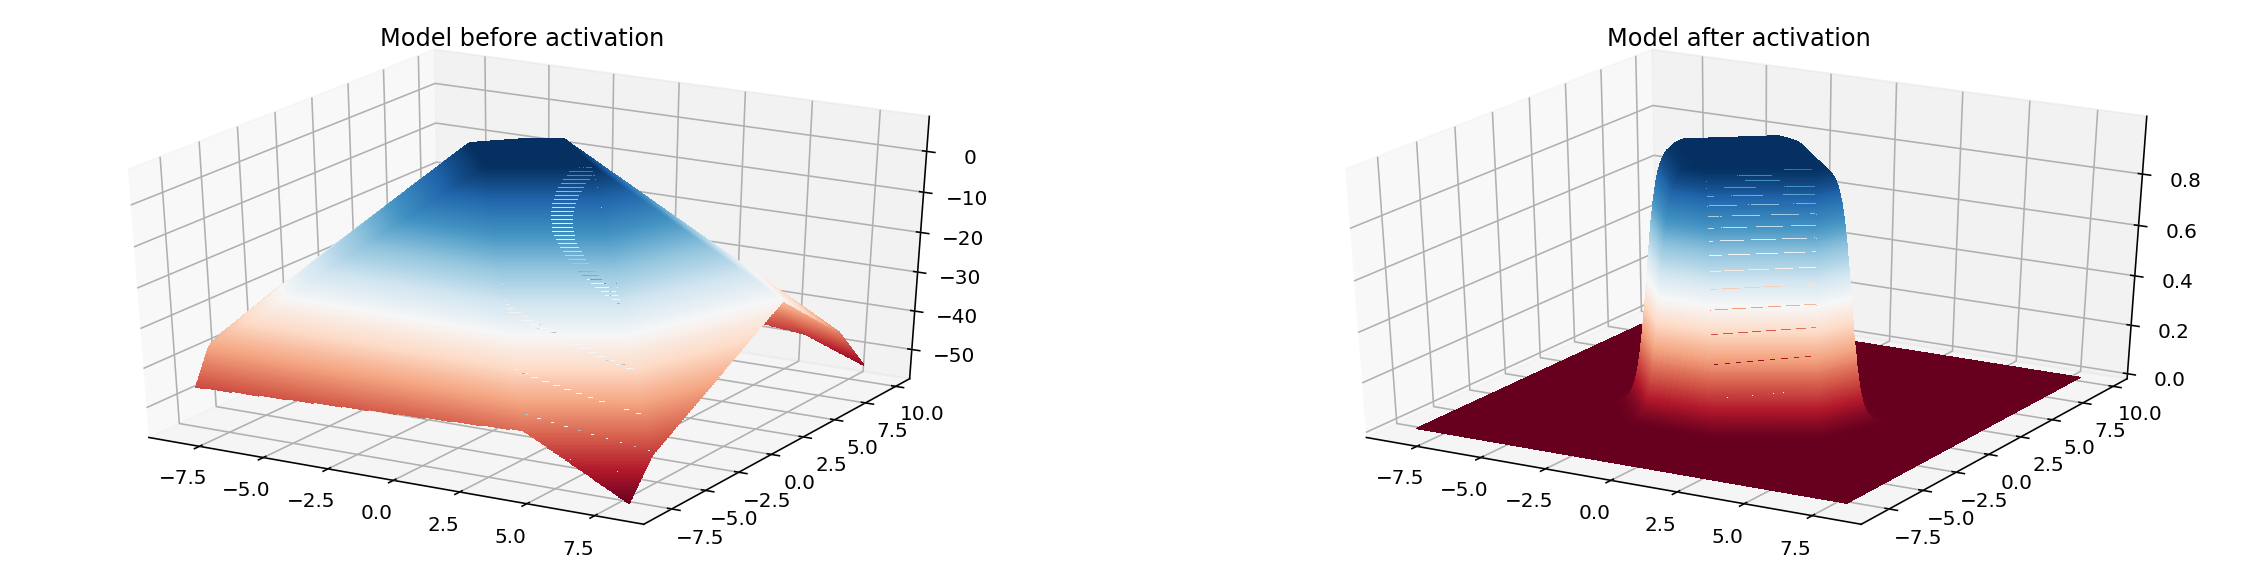

In [362]:
# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(30,5))
Z_lr_sum = 0
for i in range(hidden_units):
    ax = fig.add_subplot(1, hidden_units, i+1, projection='3d')
    ax.contourf(X1, X2, Z_lr_array[i], 256, cmap=plt.cm.RdBu) #, cmap=cm_blues)
    ax.set_title(f'Submodel {i+1} Output')
    Z_lr_sum = Z_lr_sum + Z_lr_array[i]  * model.get_weights()[2][i][0] 
plt.show()
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.contourf(X1, X2, Z_lr_sum + model.get_weights()[3][0], 256, cmap=plt.cm.RdBu) #, cmap=cm_blues)
ax.set_title(f'Model before activation')
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.contourf(X1, X2, sigmoid(Z_lr_sum + model.get_weights()[3][0]), 256, cmap=plt.cm.RdBu)
ax.set_title(f'Model after activation')
plt.show()

In [279]:
# Notar que en los gráficos se ve que parece estar al reves.
model.get_weights()[2]

array([[6.054812 ],
       [6.0393834],
       [6.0406017]], dtype=float32)

In [280]:
model.get_weights()[3]

array([-11.75357], dtype=float32)

In [281]:
# Por eso los pesos del siguiente submodelo (el que combina los dos) son negativos

# Espacio linealmente separable

In [315]:
X_sub_preds = []
for i in range(hidden_units):
    X_sub_preds.append(sub_models[i].predict(X))

In [316]:
# Calculamos la ubicación de las observaciones en el nuevo espacio
new_space = np.hstack(X_sub_preds)

In [317]:
new_space.shape

(300, 10)

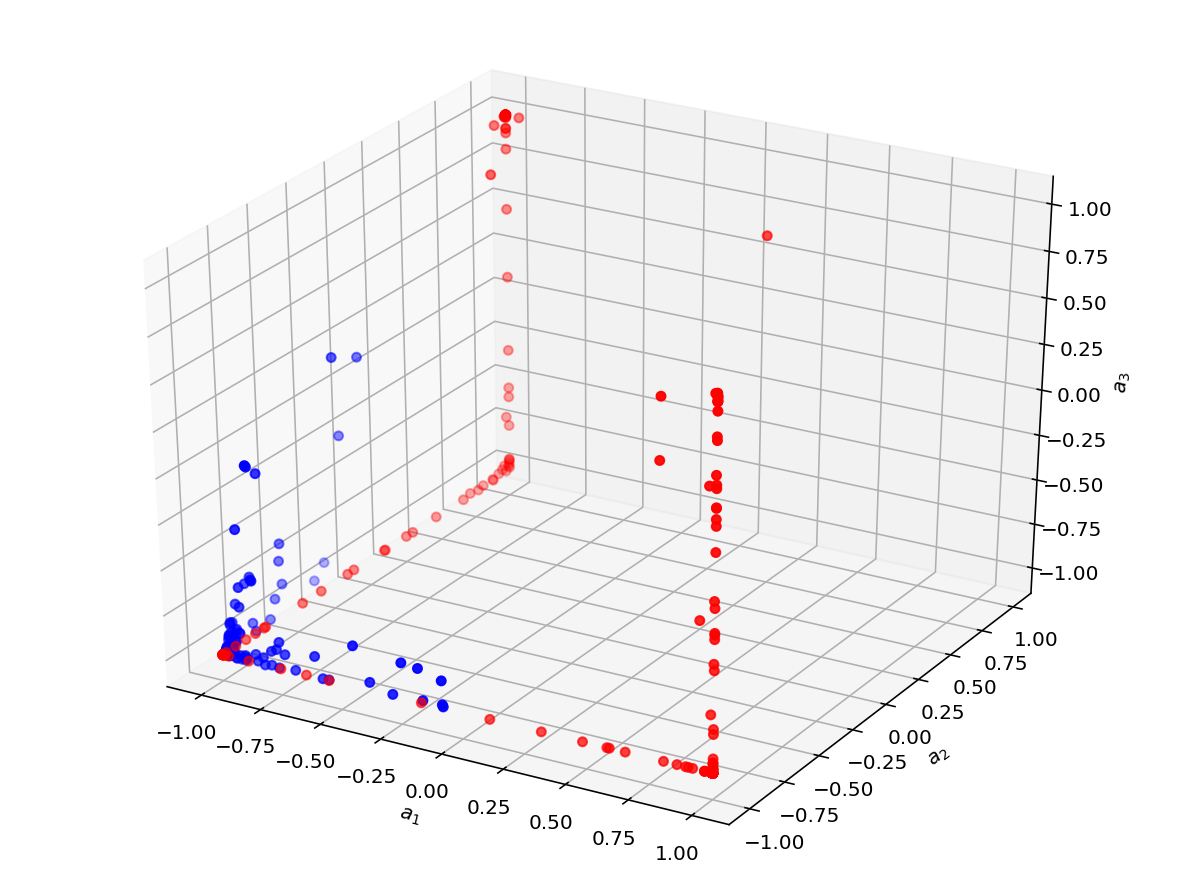

In [318]:
# Graficamos los puntos en el nuevo espacio

if hidden_units == 2:
    plt.scatter(new_space[y==1,0], new_space[y==1,1])
    plt.scatter(new_space[y==0,0], new_space[y==0,1])
    plt.show()
else:
    fig = plt.figure(figsize=(8,6))
    ax = Axes3D(fig)
    ax.scatter(new_space[y==0,0], new_space[y==0,1], new_space[y==0,2], c='r')
    ax.scatter(new_space[y==1,0], new_space[y==1,1], new_space[y==1,2], c='b')
    ax.set_xlabel('$a_1$')
    ax.set_ylabel('$a_2$')
    ax.set_zlabel('$a_3$')

In [256]:
# Creo el submodelo de la salida. Lleva sigmoidea por que es ya la predicción
sub_model_3 = get_sub_model(model, 0, 2, 3, activation='sigmoid', input_dim=hidden_units)

In [257]:
sub_model_3.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 1)                 4         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [258]:
weights_3 = sub_model_3.get_weights()
weights_3

[array([[-4.349831 ],
        [-4.571307 ],
        [-5.2793202]], dtype=float32), array([7.341468], dtype=float32)]

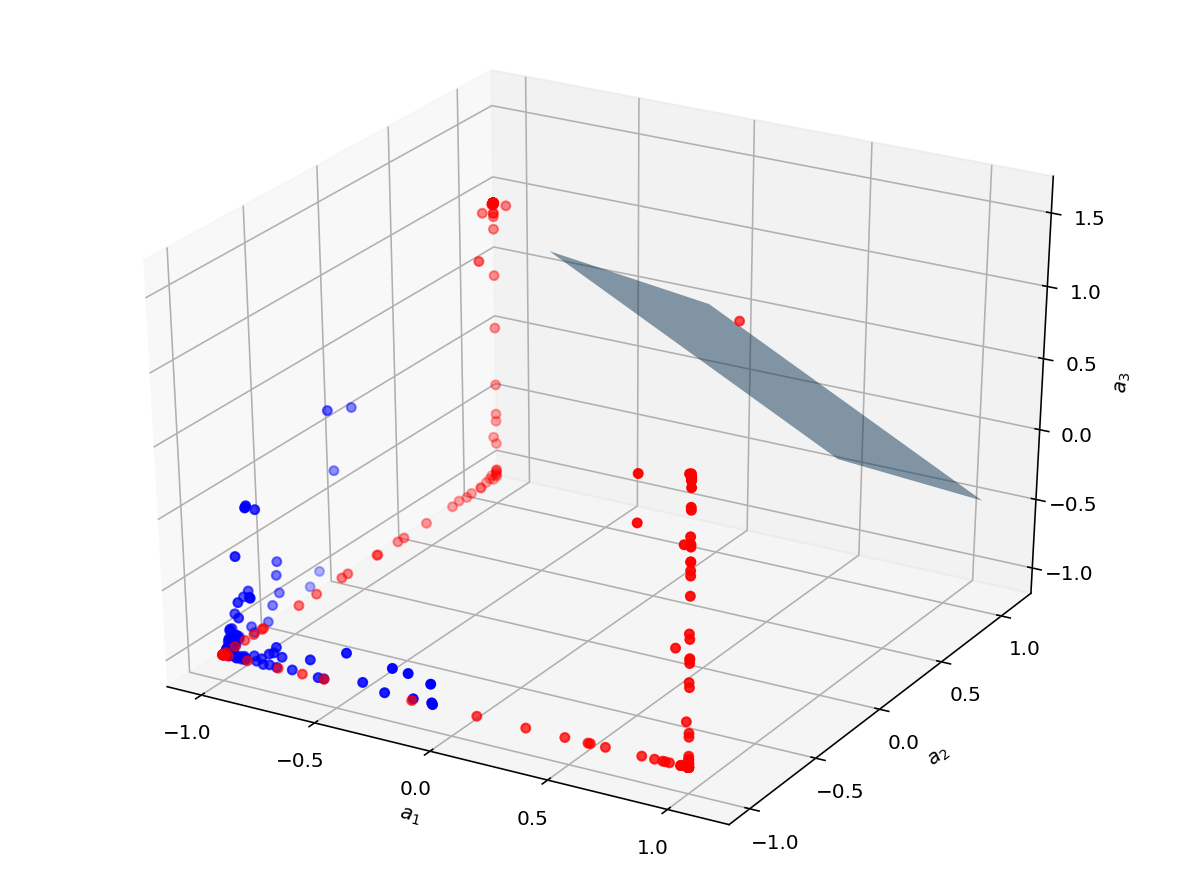

In [319]:
if hidden_units == 2:
    plot_boundaries_keras(new_space, y, sub_model_3.evaluate(new_space,y)[1], probability_func=sub_model_3.predict_proba, h=0.2)
else:
    # %matplotlib widget
    N=2
    xi, yi = np.meshgrid(np.linspace(-0.1, 1.1, N), np.linspace(-0.1, 1.1, N))
    z = (- xi*weights_3[0][0, 0 ] - yi*weights_3[0][1, 0] - weights_3[1][0])/weights_3[0][2,0]
    z = z 
    fig = plt.figure(figsize=(8,6))
    ax = Axes3D(fig)
    ax.plot_surface(xi, yi, z, alpha= 0.5)
    ax.scatter(new_space[y==0,0], new_space[y==0,1], new_space[y==0,2], c='r')
    ax.scatter(new_space[y==1,0], new_space[y==1,1], new_space[y==1,2], c='b')
    # ax.view_init(elev=20., azim=60)
    ax.set_xlabel('$a_1$')
    ax.set_ylabel('$a_2$')
    ax.set_zlabel('$a_3$')
    plt.show()